In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax
import jax.numpy as jnp
from jax import grad, jacfwd, jacrev
import equinox as eqx

In [ ]:

def barrier_heighth(energy_model, p1, p2):
    def energy_fn(x):
        return energy_model(x)

    # 梯gradient and  Hessian
    gradE = jax.jit(grad(energy_fn))
    hess_fun = jax.jit(jacfwd(jacrev(energy_fn)))

    # -------------------------------
    # 2) norm function
    # -------------------------------
    def norm(x):
        return jnp.linalg.norm(x)

    # -------------------------------
    # 3) Converge from any point to the minimum value (steady state)
    # -------------------------------
    def minimize_from(x0,
                    dt=0.0005,
                    tol_grad=1e-8,
                    tol_step=1e-10,
                    max_iters=5000,
                    step_init=1.0):
        x = jnp.array(x0)
        for k in range(max_iters):
            g = gradE(x)
            E_x = energy_fn(x)
            if norm(g) < tol_grad:
                break
            x_new = x - dt * g
            if norm(x_new - x) < tol_step:
                x = x_new
                break
            x = x_new
        return x, energy_fn(x), k+1

    # -------------------------------
    # 4) GAD：First order saddle point search (multiple seeds+optimal selection)
    # -------------------------------
    def gad_once(x_init, v_init,
                dt=0.0005,
                tol=1e-7,
                max_iters=5000,
                max_plateau=2000):
        """
        GAD：
        x_dot = -g + 2*(g·v) v
        v_dot = -H v + (v^T H v) v   (Normalize v after each step)
        return：saddle_x, saddle_E, path, energies, iters
        """
        x = jnp.array(x_init)
        v = jnp.array(v_init)
        v = v / norm(v)

        path = []
        energies = []

        plateau = 0
        prev_E = energy_fn(x)

        for it in range(max_iters):
            g = gradE(x)
            H = hess_fun(x)
            vHv = jnp.dot(v, H @ v)

            x_dot = -g + 2.0 * jnp.dot(g, v) * v
            v_dot = -(H @ v) + vHv * v

            x_new = x + dt * x_dot
            v_new = v + dt * v_dot
            v_new = v_new / norm(v_new)

            E_new = energy_fn(x_new)

            path.append(x_new)
            energies.append(E_new)

            # Convergence criteria: x_dot small, v-dot small (approximate), or energy stagnation
            if norm(x_new - x) < tol and norm(v_new - v) < tol:
                x, v = x_new, v_new
                break

            # Simple 'stagnation' counting to prevent long-term oscillation
            if jnp.abs(E_new - prev_E) < 1e-10:
                plateau += 1
                if plateau > max_plateau:
                    x, v = x_new, v_new
                    break
            else:
                plateau = 0

            x, v, prev_E = x_new, v_new, E_new

        path = jnp.stack(path) if len(path) else jnp.array(x)[None, :]
        energies = jnp.array(energies) if len(energies) else jnp.array([energy_fn(x)])
        # Approximate saddle point: Take the highest energy point in the path
        idx = int(jnp.argmax(energies))
        saddle_x = path[idx]
        saddle_E = energies[idx]
        return saddle_x, saddle_E, path, energies, it+1

    def hessian_index(x):
        """ Return the number of negative eigenvalues (exponential/saddle point order) and all eigenvalues of Hessian """
        H = hess_fun(x)
        vals = jnp.linalg.eigvalsh(H)
        neg = int(jnp.sum(vals < 0))
        return neg, vals

    def find_saddle_between_minima(m1, m2, eps=1e-3):
        """
        Multiple GAD startup points:
        (1) m1 + eps * dir(m2-m1), v = dir(m2-m1)
        (2) midpoint = (m1+m2)/2,   v = dir(m2-m1)
        (3) m2 - eps * dir(m2-m1), v = dir(m1-m2)
        Select the saddle point with index-1 and the lowest energy (if none of them are index-1, select the one with the lowest energy).
        """
        d = m2 - m1
        d = d / (norm(d) + 1e-12)

        seeds = [
            (m1 + eps * d, d),
            (0.5 * (m1 + m2), d),
            (m2 - eps * d, -d),
        ]

        candidates = []
        for x0, v0 in seeds:
            sx, sE, _, _, _ = gad_once(x0, v0)
            idx, eigs = hessian_index(sx)
            candidates.append((sE, sx, idx, eigs))

        # pre-screening index-1，
        idx1 = [(E, x, idx, eigs) for (E, x, idx, eigs) in candidates if idx == 1]
        pool = idx1 if len(idx1) > 0 else candidates
        pool.sort(key=lambda t: float(t[0]))  # 选能量最低
        bestE, bestx, bestidx, besteigs = pool[0]
        return bestx, bestE, bestidx, besteigs

    # -------------------------------
    # 5) Given two points, calculate the potential barrier
    # -------------------------------
    def barrier_from_points(p1, p2,
                            same_min_tol=1e-6):
        # Each converges to a minimum value
        m1, Em1, it1 = minimize_from(p1)
        m2, Em2, it2 = minimize_from(p2)

        # Is it the same minimum value?
        if norm(m1 - m2) < same_min_tol:
            result = {
                "min1": m1, "E_min1": float(Em1),
                "min2": m2, "E_min2": float(Em2),
                "same_minimum": True,
                "barrier_from_min1": 0.0,
                "barrier_from_min2": 0.0,
                "saddle_x": m1,     # Essentially, there is no need for saddle points
                "saddle_E": float(Em1),
                "hessian_index": 0,
                "hessian_eigs": jnp.linalg.eigvalsh(hess_fun(m1)),
                "desc_iters": (it1, it2)
            }
            return result

        # Different minima: finding the saddle point
        sx, sE, sidx, seigs = find_saddle_between_minima(m1, m2)

        barrier1 = float(sE - Em1)
        barrier2 = float(sE - Em2)

        result = {
            "min1": m1, "E_min1": float(Em1),
            "min2": m2, "E_min2": float(Em2),
            "same_minimum": False,
            "saddle_x": sx, "saddle_E": float(sE),
            "hessian_index": int(sidx),
            "hessian_eigs": seigs,
            "barrier_from_min1": barrier1,
            "barrier_from_min2": barrier2,
            "desc_iters": (it1, it2)
        }
        return result

    return barrier_from_points(p1, p2)
# -------------------------------
# results
# -------------------------------
p1 = jnp.array([0, 1.5, 0]) 
p2 = jnp.array([0, -1.5, 0])


from omegaconf import OmegaConf
from utils_reduced_polymer import build_OnsagerNetHD2_scale 
seed = 0
data_set_key = "F4_63_T1"

data_set_key_list=[
    "F23_10_T1", "F16_20_T1", "F11_60_T1", "F4_63_T1", 
                   "F3_93_T1", 
                   "F2_78_T1", "F2_31_T1", "F1_62_T1"]

def scale_number(F):
    return 2**(F/3)/3
scale_list={"F23_10_T1": scale_number(23.1), "F16_20_T1": scale_number(16.2), "F11_60_T1":scale_number(11.6),"F4_63_T1": scale_number(4.63), 
            "F3_93_T1": scale_number(3.93), "F2_78_T1": scale_number(2.78), "F2_31_T1": scale_number(2.31), "F1_62_T1": scale_number(1.62)}

p1_list={"F23_10_T1": jnp.array([1,  1.8, 0]), "F16_20_T1": jnp.array([1,  1.8, 0]), "F11_60_T1":jnp.array([0.8,  1.8, 0]), "F4_63_T1": jnp.array([0,  1.5, 0]), 
         "F3_93_T1": jnp.array([-0.5, 1.2, 0]), "F2_78_T1": jnp.array([-1.,  1, 0]), "F2_31_T1": jnp.array([-1.,  1, 0]), "F1_62_T1": jnp.array([-1.5, 0.5, 0])}
p2_list={"F23_10_T1": jnp.array([1, -1.8, 0]), "F16_20_T1": jnp.array([1, -1.8, 0]), "F11_60_T1":jnp.array([0.8, -1.8, 0]), "F4_63_T1": jnp.array([0, -1.5, 0]), 
         "F3_93_T1": jnp.array([-0.5, -1.2, 0]), "F2_78_T1": jnp.array([-1., -1, 0]), "F2_31_T1": jnp.array([-1., -1, 0]), "F1_62_T1": jnp.array([-1.5, -0.5, 0])}

bh_all_key={}
for data_set_key in data_set_key_list:
    print(f"================ {data_set_key} ================")
    p1 = p1_list[data_set_key]
    p2 = p2_list[data_set_key]
    print(scale_list[data_set_key])
    bh = {}
    for seed in [0,1, 12, 123]:
        path =  f"outputs/main{seed}_HD2"
        config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
        model_template = build_OnsagerNetHD2_scale(config) 
        net = eqx.tree_deserialise_leaves(os.path.join(path,data_set_key + '/model.eqx'), model_template) 

        def energy_model(z): 
            return net.potential(z, [config.temperature])/scale_list[data_set_key]
        out = barrier_heighth(energy_model, p1, p2)
        print(f"""
                    ========== seed={seed} ==========
                    Minimum 1: {out['min1']} | Energy: {out['E_min1']}
                    Minimum 2: {out['min2']} | Energy: {out['E_min2']}
                    Same Minimum: {out['same_minimum']}
                    Saddle Point: {out['saddle_x']} | Energy: {out['saddle_E']}
                    Hessian Index (expect 1): {out['hessian_index']}
                    Barrier from min1: {out['barrier_from_min1']}
                    Barrier from min2: {out['barrier_from_min2']}
                    ---------------------------------
                    """)
        bh[seed] = out
    bh_all_key[data_set_key] = bh


================ F23_10_T1 ================
69.31220448906544

                    ========== seed=0 ==========
                    Minimum 1: [0.8864782  1.8213668  0.19897248] | Energy: 1.7562313079833984
                    Minimum 2: [ 0.886528   -1.8188653  -0.16703485] | Energy: 2.199801445007324
                    Same Minimum: False
                    Saddle Point: [8.8107026e-01 6.4096687e-04 1.5760567e-02] | Energy: 28.68316078186035
                    Hessian Index (expect 1): 1
                    Barrier from min1: 26.926929473876953
                    Barrier from min2: 26.483360290527344
                    ---------------------------------
                    

                    ========== seed=1 ==========
                    Minimum 1: [0.8864037 1.8213761 0.1987704] | Energy: 1.7772126197814941
                    Minimum 2: [ 0.8863286  -1.8188446  -0.16625707] | Energy: 1.1478092670440674
                    Same Minimum: False
                    Saddle Poin

In [ ]:
bh_list=[]
for key in bh_all_key: 
    for seed in bh_all_key[key]:
        out = bh_all_key[key][seed]
        bh_list.append(out['barrier_from_min1']*scale_list[key])
import numpy as np
bh_array=np.array(bh_list).reshape(-1, 4)
print(bh_array)
bh_array=np.array([[1.86636484e+03, 1.54065242e+03, 1.09348606e+03, 1.05778992e+03],
 [1.58417283e+20, 8.15478332e+02, 1.12926328e+03, 7.56177952e+02],
 [4.58486156e+02, 4.43171474e+02, 5.20065450e+02, 4.49034455e+02],
 [1.15197981e+02, 1.14270587e+02, 1.76472862e+02, 1.16447614e+02],
 [1.56684392e+02, 7.47027236e+01, 1.56072016e+02, 7.79956657e+01],
 [3.52842631e+01, 3.42077481e+01, 3.57401703e+01, 3.48126521e+01],
 [2.06000481e+01, 2.07717737e+01, 2.01941046e+01, 2.05597859e+01],
 [7.16795739e+00, 6.93030523e+00, 7.41274877e+00, 7.44645094e+00]])

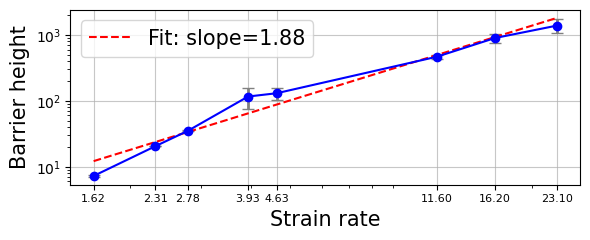

In [ ]:
import numpy as np


#Remove outliers
row_idx, col_idx = 1, 0
valid_values = bh_array[row_idx, 1:]
replacement = np.mean(valid_values)
bh_array[row_idx, col_idx] = replacement

import numpy as np
import matplotlib.pyplot as plt

means = np.mean(bh_array, axis=1)
stds = np.std(bh_array, axis=1)
F_list = [23.1, 16.2, 11.6, 4.63, 3.93, 2.78, 2.31, 1.62]

log_F = np.log10(F_list)
log_means = np.log10(means)
log_stds = stds / (means * np.log(10))  # 

plt.figure(figsize=(6, 2.5))


plt.errorbar(F_list, means, yerr=stds, fmt='o-', color='b', ecolor='gray', 
             elinewidth=2, capsize=4)

#
coefficients = np.polyfit(log_F, log_means, 1)
slope, intercept = coefficients


log_F_fit = np.linspace(np.log10(min(F_list)), np.log10(max(F_list)), 100)
log_fit_line = slope * log_F_fit + intercept


F_fit = 10**log_F_fit
fit_line = 10**log_fit_line

plt.plot(F_fit, fit_line, linestyle='--', color='r', 
         label=f'Fit: slope={slope:.2f}')


plt.xscale('log')
plt.yscale('log')
plt.xticks(F_list, [f'{x:.2f}' for x in F_list], fontsize=8)
plt.xlabel('Strain rate', fontsize=15)
plt.ylabel('Barrier height', fontsize=15)
plt.grid(True, ls="-", alpha=0.7)
plt.legend(fontsize=15)
plt.tight_layout() 
plt.savefig("barrier_height_h2o.svg") 